# CellRank Plots

## Estimate terminal states

In [ ]:
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import cellrank as cr
import matplotlib.pyplot as plt
import pickle

Path='/home/mgander/pancreas_multiome/data2'
adata=sc.read_h5ad(f'{Path}/Intestinal_epithelial_adata.h5ad')
with open(f'{Path}/dpt.pkl', 'rb') as handle:
    dpt = pickle.load(handle)

In [ ]:
#ck=cr.kernels.PrecomputedKernel((dpt+cyto)/2, adata=adata)
ck=cr.kernels.PrecomputedKernel(dpt, adata=adata)

g = cr.estimators.GPCCA(ck)
g.compute_schur(n_components=20, method="krylov")
g.compute_macrostates(n_states=20, cluster_key="level_2")
g.predict_terminal_states(method="top_n", n_states=13)

In [ ]:
fwd=adata.obs['term_states_fwd']
g.set_terminal_states({"Microfold cells": adata[fwd=='Microfold cells_2'].obs_names,
                    "Basal cells": adata[fwd=='basal cells'].obs_names,
                    "Colonocytes": adata[fwd=='colonocytes'].obs_names,
                    "Cycling endothelial cells": adata[fwd=='cycling endothelial cells'].obs_names,
                    "Enterocytes": adata[fwd=='enterocytes_4'].obs_names, 
                    "Goblet cells": adata[fwd=='goblet cells_2'].obs_names, 
                    "Enteroendocrine cells": adata[fwd=='enteroendocrine cells'].obs_names, 
                    "Tuft cells": adata[fwd=='tuft cells_1'].obs_names,
                    "Stem cell":adata[fwd=='stem cells_5'].obs_names})

In [ ]:
df=adata.obs
df.to_pickle(f'{Path}/adata_obs_post.pkl')

In [ ]:
g.compute_fate_probabilities(tol=10**-7, preconditioner='ilu')
drivers=g.compute_lineage_drivers()
drivers.to_pickle(f'{Path}/drivers_epithelial2.pkl')

In [ ]:
drivers=pd.read_pickle(f'{Path}/drivers_epithelial.pkl')

In [ ]:
dpt_obs=pd.read_pickle(f'{Path}/dpt_epithelial.pkl')
adata.obs['latent_time']=dpt_obs['dpt_pseudotime']

## Compute and save gene expression over pseudotime

In [ ]:
model = cr.models.GAM(adata)
def save_celltype_heatmap(celltype, n_genes=5):
    genes=drivers.sort_values(f'{celltype}_corr', ascending=False).head(n_genes).index
    
    a=cr.pl.heatmap(
    adata,
    model=model,  # use the model from before
    lineages=celltype,
    cluster_key=None,
    show_fate_probabilities=False,
    genes=genes,
    time_key="latent_time",
    figsize=(6, 5),
    fontsize=16,
    show_all_genes=True,
    weight_threshold=(1e-3, 1e-3),
    save=True)
    a.fig.subplots_adjust(bottom=0.08)
    a.fig.subplots_adjust(right=0.85)
    a.fig.subplots_adjust(left=-0.05)
    a.fig.subplots_adjust(top=1.1)
    a.fig.savefig(f'/home/mgander/figures/{celltype}.pdf', dpi=300, format="pdf")

In [ ]:
model = cr.models.GAM(adata)
def save_celltype_heatmap(celltype, n_genes=5):
    genes=drivers.sort_values(f'{celltype}_corr', ascending=False).head(n_genes).index
    
    a=cr.pl.heatmap(
    adata,
    model=model,  # use the model from before
    lineages=celltype,
    cluster_key=None,
    show_fate_probabilities=False,
    genes=genes,
    time_key="latent_time",
    figsize=(6, 5),
    fontsize=16,
    show_all_genes=True,
    weight_threshold=(1e-3, 1e-3),
    save=True)
    a.fig.subplots_adjust(bottom=0.1)
    a.fig.subplots_adjust(right=0.8)
    a.fig.subplots_adjust(left=-0)
    a.fig.subplots_adjust(top=1.1)
    a.fig.savefig(f'/home/mgander/figures/full_epithelial_data/{celltype}.pdf', dpi=300, format="pdf")
    a.fig.savefig(f'/home/mgander/figures/full_epithelial_data/{celltype}.png', dpi=300, format="png")

In [ ]:
save_celltype_heatmap('Basal cells', n_genes=5)
save_celltype_heatmap('Colonocytes', n_genes=5)
save_celltype_heatmap('Enterocytes', n_genes=5)
save_celltype_heatmap('Microfold cells', n_genes=5)
save_celltype_heatmap('Cycling endothelial cells', n_genes=6)
save_celltype_heatmap('Goblet cells', n_genes=5)
save_celltype_heatmap('Enteroendocrine cells', n_genes=6)
save_celltype_heatmap('Tuft cells', n_genes=6)

# UMAP plots

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import cellrank as cr
import matplotlib.pyplot as plt
import pickle
plt.rcParams['figure.dpi'] = 300

Path='/home/mgander/pancreas_multiome/data2'
adata=sc.read_h5ad(f'{Path}/Intestinal_epithelial_adata.h5ad')
adata

AnnData object with n_obs × n_vars = 267256 × 21044
    obs: 'sample_id', 'publication', 'sample_name', 'tissue', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'batch', 'derive', 'detail_tissue', 'time', 'protocol', 'tech_detail', 'molecular', 'gel', 'leiden', 'leiden_10.0', 'level_1', 'level_2', 'level_3', 'level_1_original', 'level_2_original', 'level_3_original', 'tissue_ontology_term_id', 'organism_ontology_term_id', 'assay_ontology_term_id', 'disease_ontology_term_id', 'cell_type_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'development_stage_ontology_term_id', 'sex_ontology_term_id', 'donor_id', 'suspension_type', 'day'
    var: 'gene_name', 'ENSG', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'level_1_colors', 'level_2_colors', 'neighbors', 'umap'
    obsm: 'X_scPoli', 'X_umap', 'X_umap_initial', 'X_umap_min', 'X_umap_sc'
    obsp: 'connecti

In [2]:
df=pd.read_pickle(f'{Path}/adata_obs_pre.pkl')
adata.obs['macrostates_fwd']=list(df['macrostates_fwd'])

/home/mgander/miniconda3/envs/mc/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


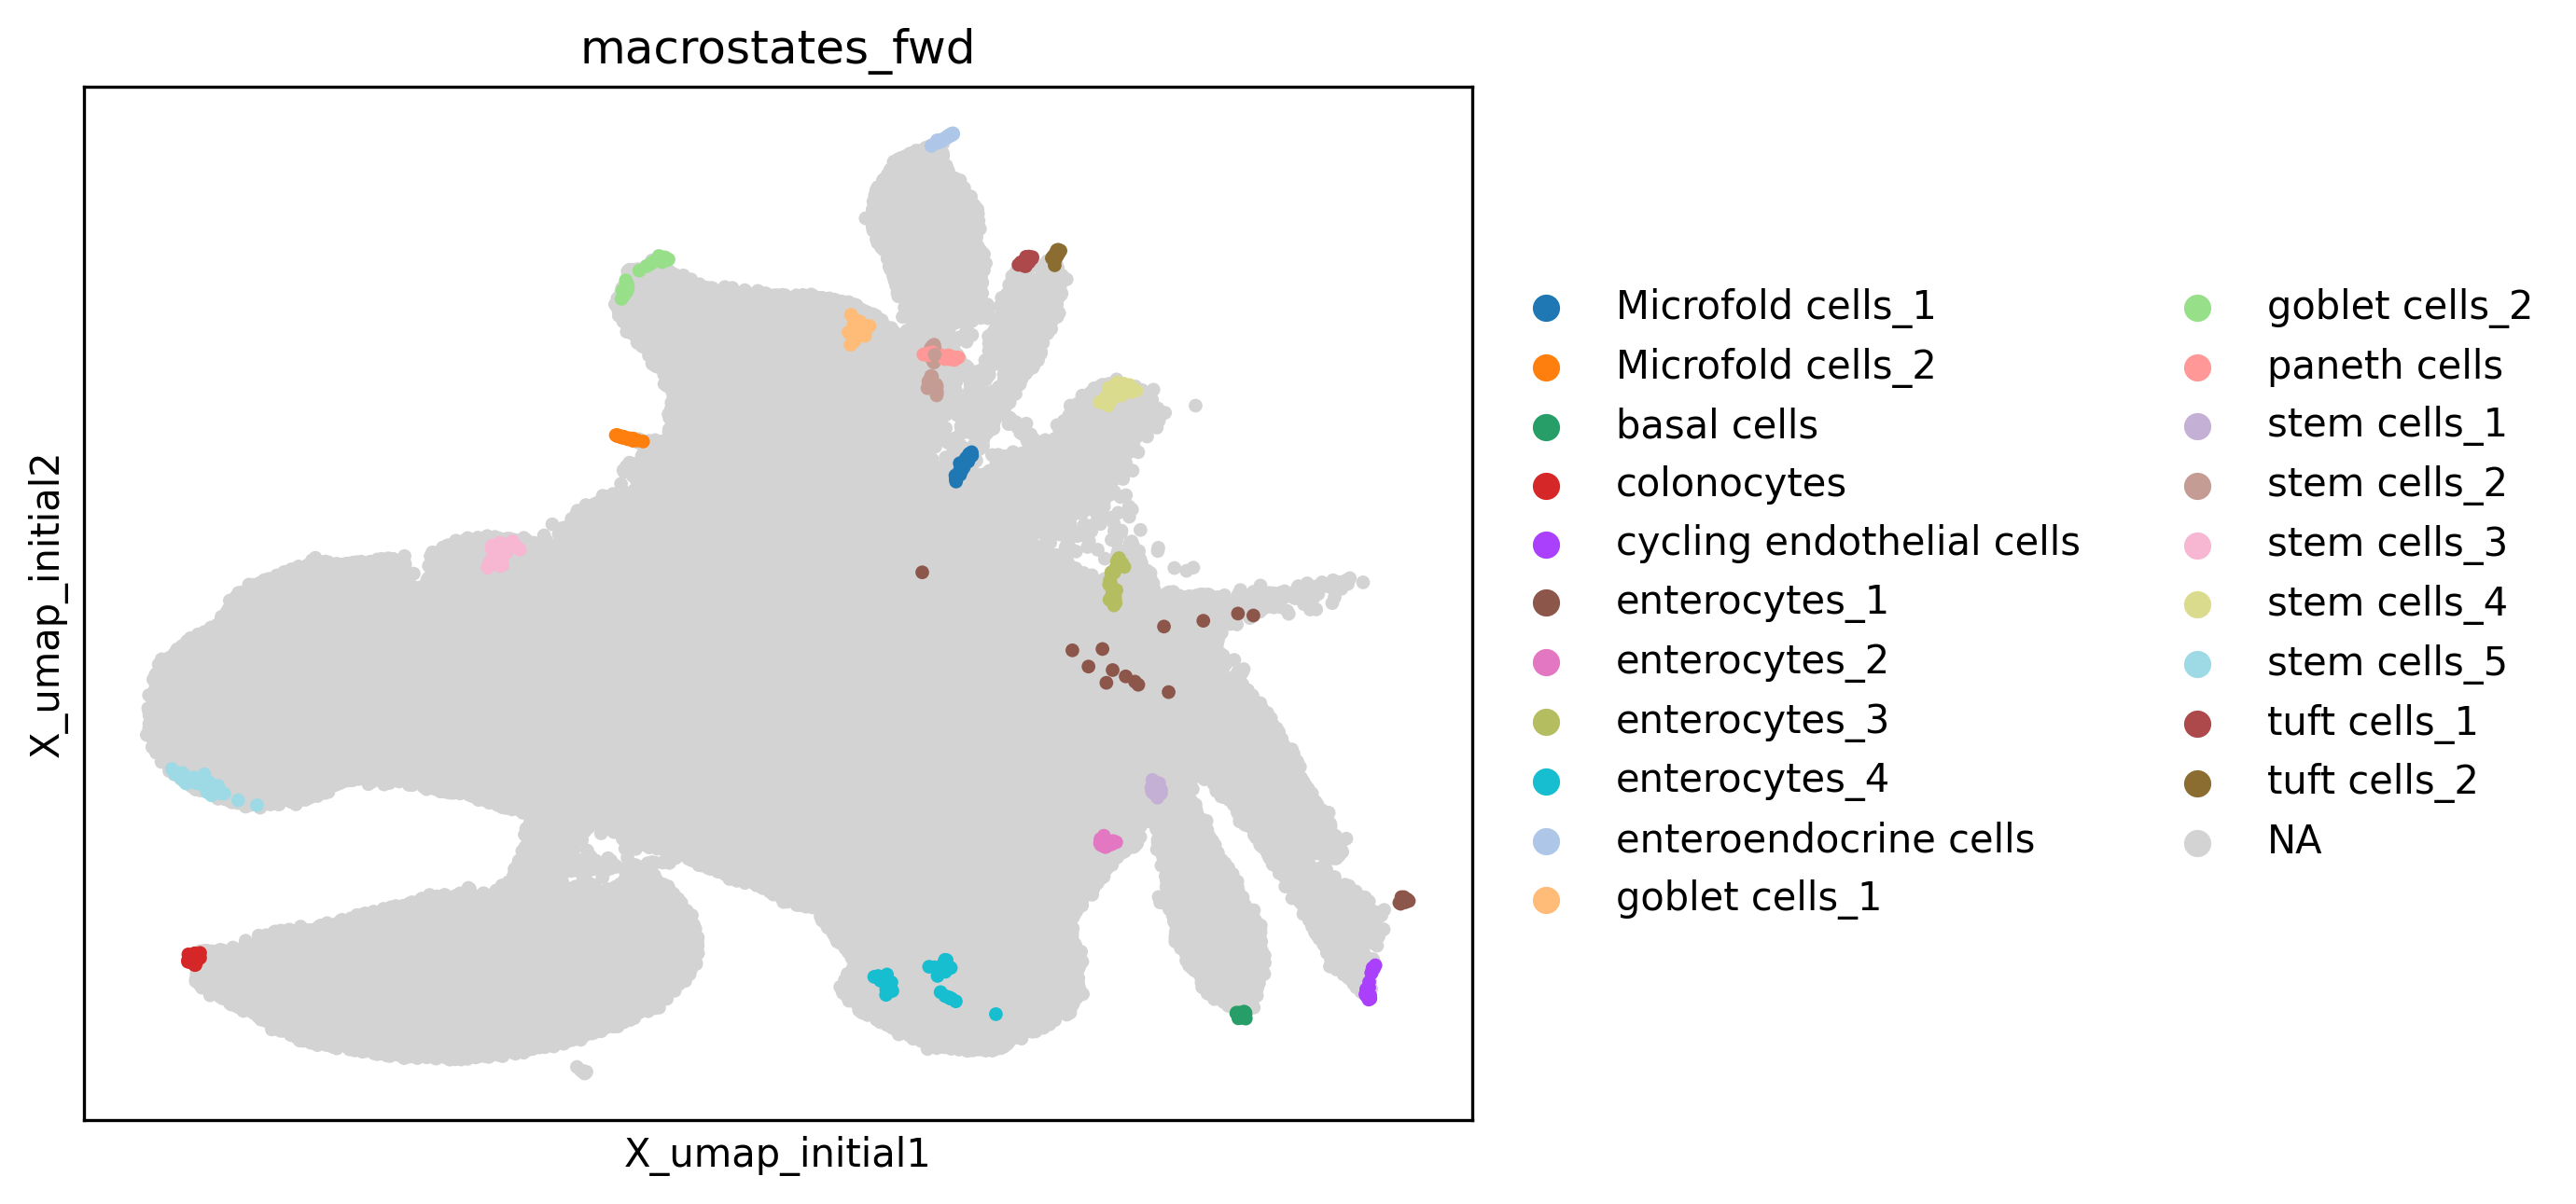

In [3]:
sc.pl.embedding(adata, basis='X_umap_initial', color='macrostates_fwd', size=50)

In [6]:
df=pd.read_pickle(f'{Path}/adata_obs_post.pkl')
adata.obs['macrostates_fwd']=list(df['macrostates_fwd'])
adata.obs['term_states_fwd']=list(df['term_states_fwd'])

/home/mgander/miniconda3/envs/mc/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


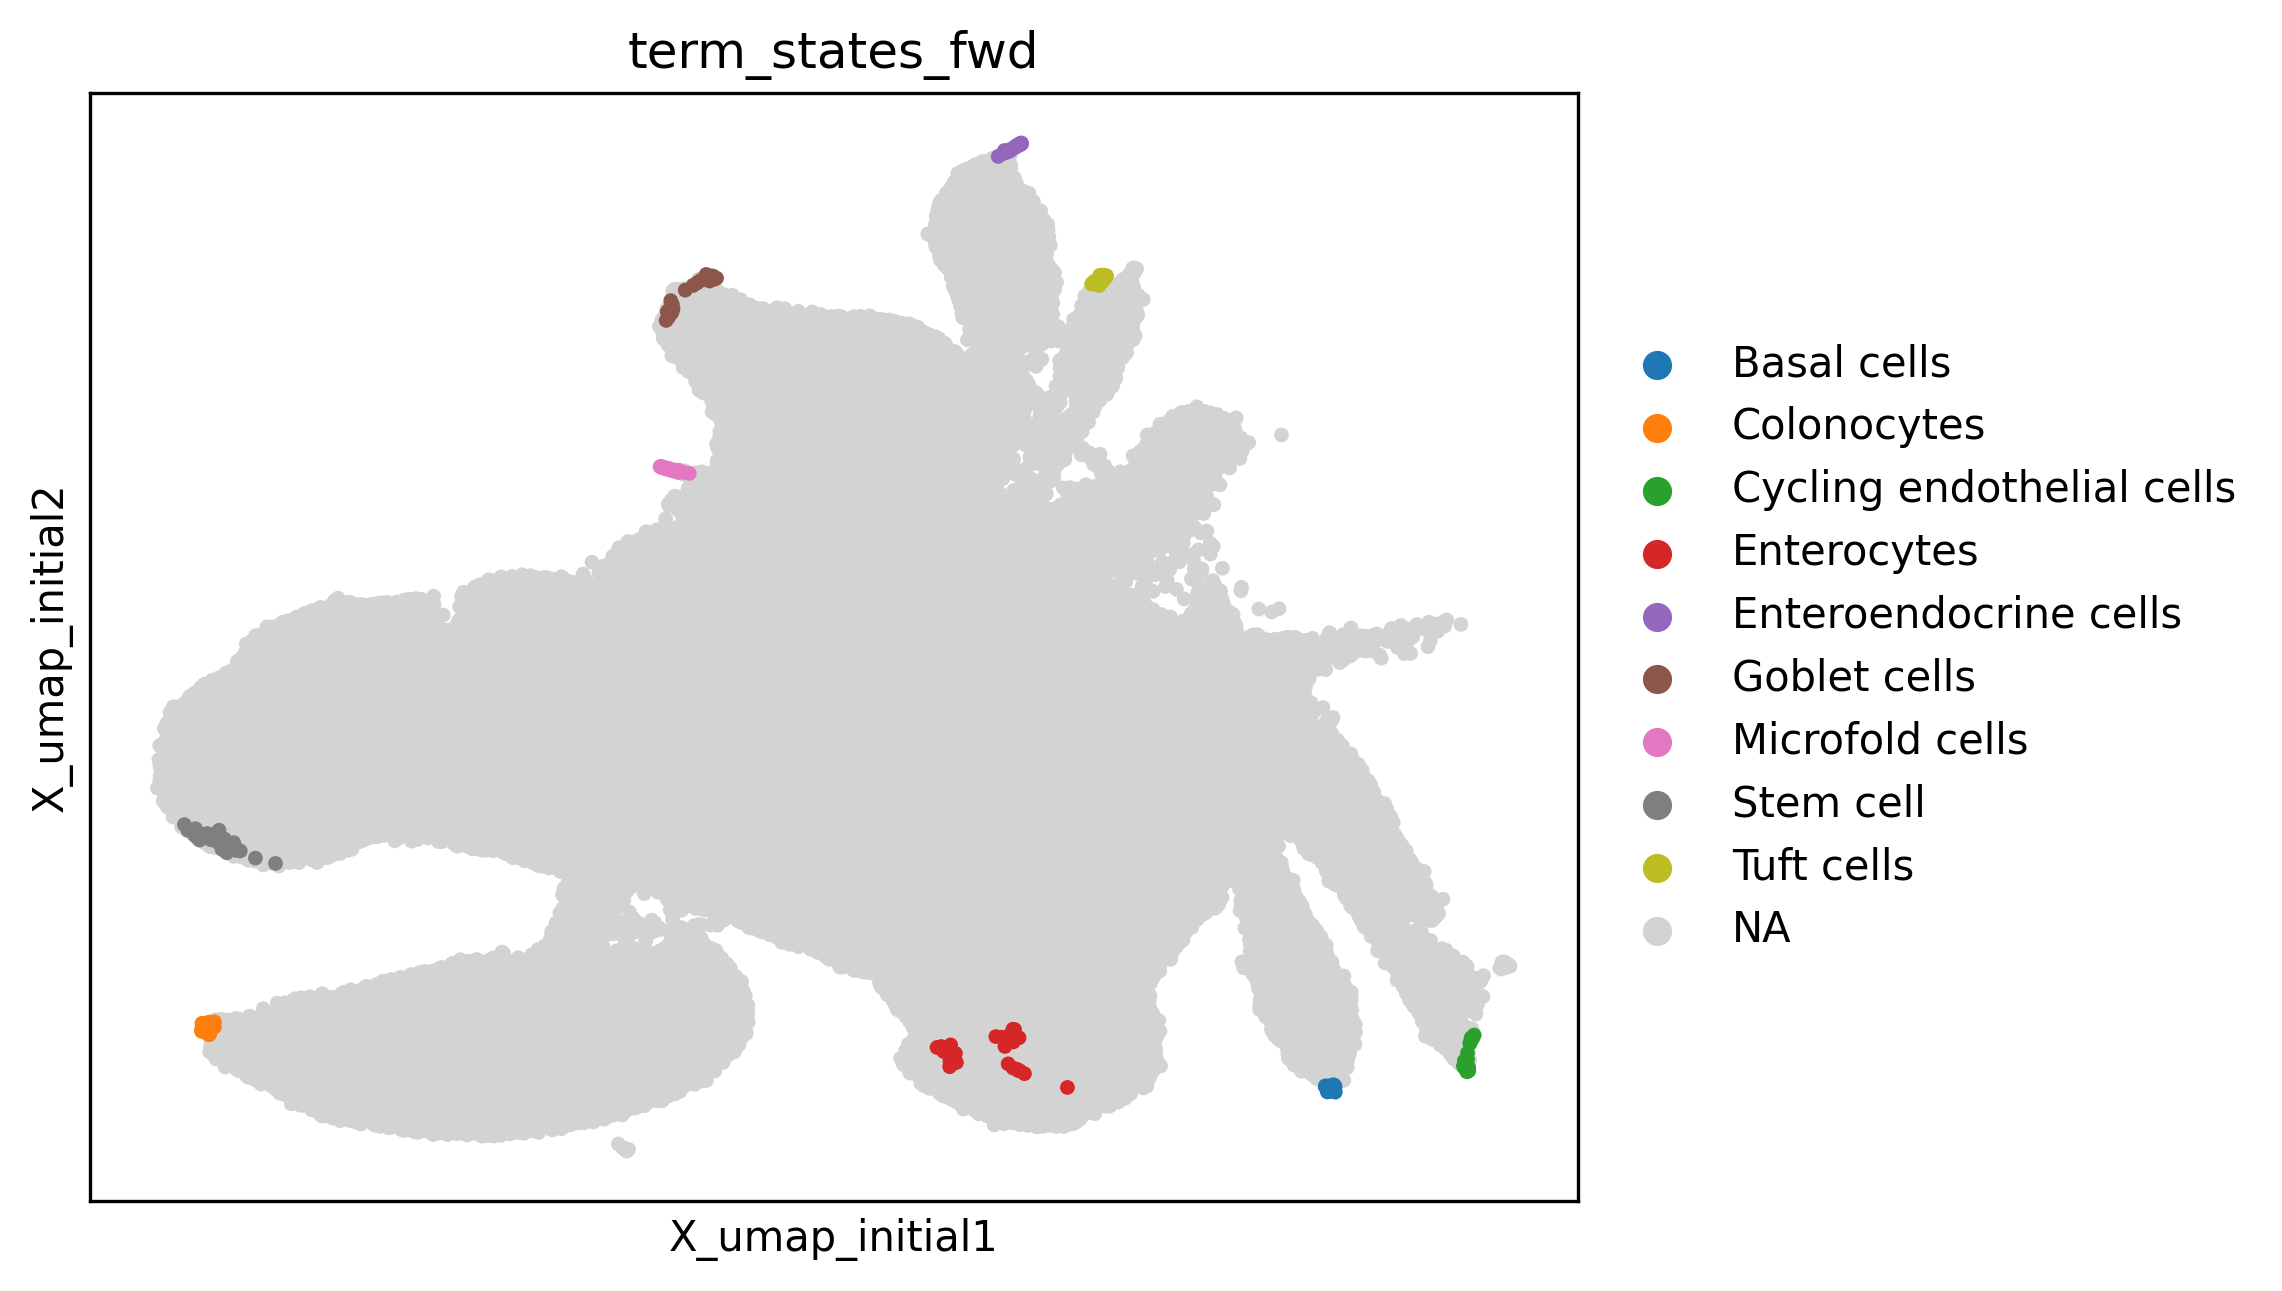

In [7]:
sc.pl.embedding(adata, basis='X_umap_initial', color='term_states_fwd', size=50)

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import cellrank as cr
import matplotlib.pyplot as plt
import pickle
plt.rcParams['figure.dpi'] = 300

In [4]:
Path='/home/mgander/pancreas_multiome/data2'
drivers=pd.read_pickle(f'{Path}/drivers_epithelial2.pkl')
drivers

,Basal cells_corr,Basal cells_pval,Basal cells_qval,Basal cells_ci_low,Basal cells_ci_high,Colonocytes_corr,Colonocytes_pval,Colonocytes_qval,Colonocytes_ci_low,Colonocytes_ci_high,...,Stem cell_corr,Stem cell_pval,Stem cell_qval,Stem cell_ci_low,Stem cell_ci_high,Tuft cells_corr,Tuft cells_pval,Tuft cells_qval,Tuft cells_ci_low,Tuft cells_ci_high
gene_name,,,,,,,,,,,,,,,,,,,,,
MIR205HG,0.529271,0.0,0.0,0.526536,0.531995,-0.088499,0.000000e+00,0.000000e+00,-0.092260,-0.084736,...,-0.094237,0.000000e+00,0.000000e+00,-0.097993,-0.090478,-0.034424,6.681928e-71,4.745680e-70,-0.038210,-0.030637
KRT17,0.464188,0.0,0.0,0.461208,0.467157,-0.108528,0.000000e+00,0.000000e+00,-0.112273,-0.104780,...,0.367937,0.000000e+00,0.000000e+00,0.364654,0.371210,-0.038144,1.220825e-86,1.025181e-85,-0.041929,-0.034358
MEIS2,0.457017,0.0,0.0,0.454013,0.460012,-0.145228,0.000000e+00,0.000000e+00,-0.148937,-0.141515,...,0.048264,1.287607e-137,4.526630e-137,0.044481,0.052046,-0.061378,1.658405e-221,3.662065e-220,-0.065155,-0.057601
MIR99AHG,0.453725,0.0,0.0,0.450709,0.456731,-0.057943,1.410600e-197,6.389294e-197,-0.061720,-0.054163,...,-0.083731,0.000000e+00,0.000000e+00,-0.087494,-0.079965,-0.019336,1.566769e-23,5.226870e-23,-0.023126,-0.015546
TNNT3,0.447151,0.0,0.0,0.444112,0.450179,-0.048078,1.420832e-136,5.174799e-136,-0.051860,-0.044295,...,-0.051226,8.386603e-155,3.128105e-154,-0.055007,-0.047444,-0.017318,3.440585e-19,1.027586e-18,-0.021108,-0.013527
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LGALS3,-0.364836,0.0,0.0,-0.368118,-0.361545,0.174324,0.000000e+00,0.000000e+00,0.170646,0.177998,...,-0.134266,0.000000e+00,0.000000e+00,-0.137987,-0.130541,-0.061069,2.680279e-219,5.857091e-218,-0.064846,-0.057291
FABP1,-0.376962,0.0,0.0,-0.380210,-0.373705,0.133809,0.000000e+00,0.000000e+00,0.130084,0.137530,...,-0.419169,0.000000e+00,0.000000e+00,-0.422289,-0.416039,-0.099291,0.000000e+00,0.000000e+00,-0.103043,-0.095536
EPCAM,-0.394913,0.0,0.0,-0.398109,-0.391709,-0.011270,5.659810e-09,8.571174e-09,-0.015061,-0.007479,...,-0.210788,0.000000e+00,0.000000e+00,-0.214408,-0.207162,0.046247,1.673000e-126,2.026863e-125,0.042463,0.050030


In [6]:
drivers.to_csv(f'{Path}/drivers_epithelial.csv')